In [29]:
import numpy as np
import pandas as pd
import tables
from glob import glob
from os.path import join, exists
import matplotlib as mpl
from matplotlib import pyplot as plt
import re
from sstcam_simulation import Camera
from scipy.signal import find_peaks, peak_widths
from sstcam_simulation.performance.plot_lab_performance import extract_charge_resolution_mc, extract_trigger_efficiency
from tqdm.auto import tqdm
from CHECLabPy.plotting.resolutions import ChargeResolutionPlotter
from numpy.polynomial.polynomial import polyfit, polyval
from scipy.interpolate import griddata
%matplotlib inline

In [30]:
directory = "/Users/Jason/Software/sstcam-labbook/d200626_undershoot/cameras"
h5_paths = glob(join(directory, "*.h5"))

In [31]:
df_files = []
pattern = r".*\/undershoot_(.+)_(.+)_(.+)_lab.h5"
for h5_path in h5_paths:
    camera_path = h5_path.replace("_lab.h5", ".pkl")
    regexr = re.search(pattern, h5_path)
    ratio = float(regexr.group(1))
    sigma0 = float(regexr.group(2))
    sigma1 = float(regexr.group(3))
    
    assert exists(h5_path)
    assert exists(camera_path)
    
    camera = Camera.load(camera_path)
    x = camera.reference_pulse.time
    y = camera.reference_pulse.pulse
    sample_width = x[1] - x[0]
    
    peaks, _ = find_peaks(y)
    widths = peak_widths(y, peaks)
    pulse_width = widths[0][0] * sample_width
    
    if sigma1 == 0:
        undershoot_width = 0
    else:
        peaks, _ = find_peaks(-y)
        widths = peak_widths(-y, peaks)
        undershoot_width = widths[0][-1] * sample_width
        
    area_neg = -1 * y[y<0].sum() * sample_width
    area_pos = y[y>0].sum() * sample_width
        
    df_files.append(dict(
        h5_path=h5_path,
        camera_path=camera_path,
        ratio=ratio,
        sigma0=sigma0,
        sigma1=sigma1,
        pulse_width=pulse_width,
        undershoot_width=undershoot_width,
        measured_ratio = area_neg/area_pos,
    ))
    
df_files = pd.DataFrame(df_files).sort_values(['sigma0', 'sigma1'])

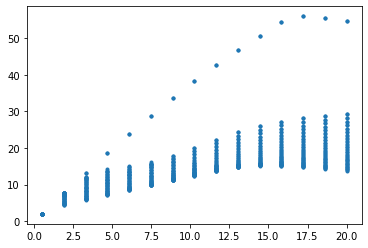

In [32]:
plt.plot(df_files['sigma0'], df_files['pulse_width'], '.')

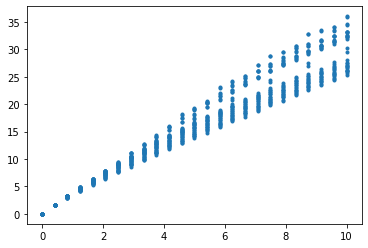

In [33]:
plt.plot(df_files['sigma1'], df_files['undershoot_width'], '.')

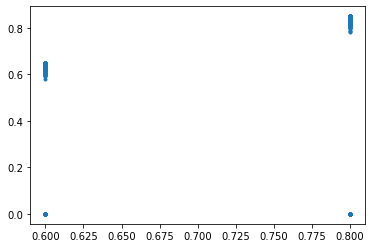

In [34]:
plt.plot(df_files['ratio'], df_files['measured_ratio'], '.')

In [35]:
# # Plot reference pulses
# mask = (df_files['sigma0'] == 1) & (df_files['ratio'] == 0.2)
# df_refpulse = df_files.loc[mask].iloc[[0, 2, 4, 10, 15, -1]]
# for _, row in df_refpulse.iterrows():
#     camera = Camera.load(row['camera_path'])
#     x = camera.reference_pulse.time
#     y = camera.reference_pulse.pulse
#     label = f"Undershoot = {row['undershoot_width']:.2f} ns"
#     plt.plot(x, y, label=label)

# plt.legend(loc=1)
# plt.xlabel("Time (ns)")
# plt.ylabel("Amplitude")
# plt.savefig("pulses.pdf")

In [36]:
# # Plot CR curves
# with tables.File(df_files.iloc[0]['h5_path'], mode='r') as file:
#     data = file.root.event[:]
#     measured_charge = data['measured_charge']
#     true_charge = data['true_charge']
# ref_cr_x, ref_cr_y = extract_charge_resolution_mc(measured_charge, true_charge)


# for _, row in df_files.iterrows():
#     with tables.File(row['h5_path'], mode='r') as file:
#         data = file.root.event[:]
#         measured_charge = data['measured_charge']
#         true_charge = data['true_charge']
    
#     cr_x, cr_y = extract_charge_resolution_mc(measured_charge, true_charge)
#     plt.plot(cr_x, cr_y, label=f"Undershoot = {row['undershoot_width']:.2f} ns")

# plt.legend(loc='best')
# plt.xscale('log')
# plt.yscale('log')

In [37]:
# Extract performance
df_list = []
for _, row in tqdm(df_files.iterrows(), total=df_files.index.size):
    with tables.File(row['h5_path'], mode='r') as file:
        data = file.root.event[:]
        illumination = data['illumination']
        n_triggers = data['n_triggers']
        measured_charge = data['measured_charge']
        true_charge = data['true_charge']
        
    # Calibrate charge
    mask = (true_charge >= 50) & (true_charge <=500)
    coeff = polyfit(true_charge[mask], measured_charge[mask], [1])
    measured_charge /= coeff[1]
    coeff = polyfit(true_charge[mask], measured_charge[mask], [1])

    teff_x, teff_y, teff_yerr = extract_trigger_efficiency(illumination, n_triggers)
    teff_50 = np.interp(0.5, teff_y, teff_x)
    
    cr_x, cr_y = extract_charge_resolution_mc(measured_charge, true_charge)
    cr_2pe = np.interp(2, cr_x, cr_y)
    cr_100pe = np.interp(100, cr_x, cr_y)
        
    df_list.append(dict(
        ratio=row['ratio'],
        sigma0=row['sigma0'],
        sigma1=row['sigma1'],
        pulse_width=row['pulse_width'],
        undershoot_width=row['undershoot_width'],
        teff_50=teff_50,
        cr_2pe=cr_2pe,
        cr_100pe=cr_100pe,
    ))

In [38]:
df = pd.DataFrame(df_list)

In [39]:
# CREATE NEW

# with pd.HDFStore("performance.h5") as store:
#     store['data'] = df

In [40]:
# APPEND

with pd.HDFStore("performance.h5") as store:
    df_old = store['data']
    df_concat = pd.concat([df, df_old], ignore_index=True)
    store['data'] = df_concat